# 杭州萧山区项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Process Analysis`*

---
*@author: Evan*\
*@date: 2023-07-13*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
import ModelEvaLib as me
from namelist import *

## 读取数据

In [2]:
pa = xr.open_dataset(pafile)

lat  = pa.latitude
lon  = pa.longitude
HNO3 = pa.HNO3prod[:,0,:,:]
H2O2 = pa.H2O2prod[:,0,:,:]

HNO3.shape

(720, 138, 135)

In [3]:
ratio=H2O2/HNO3
ratio.shape

(720, 138, 135)

In [4]:
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

In [7]:
shp_hz = gpd.read_file(shphz)
shp_xs = gpd.read_file(shpxs)
mask_hz = polygon_to_mask(shp_hz.geometry[0],lon,lat)
mask_xs = polygon_to_mask(shp_xs.geometry[0],lon,lat)

datamask = xr.DataArray(mask_hz,dims=('y','x'))
masked_hz = ratio.where(datamask)
datamask = xr.DataArray(mask_xs,dims=('y','x'))
masked_xs = ratio.where(datamask)

mean_hz = masked_hz.mean(dim=['y','x'],skipna=True)
mean_xs = masked_xs.mean(dim=['y','x'],skipna=True)
mean_hz.shape

(720,)

In [8]:
hz_day = mean_hz.resample({'time':'D'}).mean(dim='time')
xs_day = mean_xs.resample({'time':'D'}).mean(dim='time')
hz_day.shape

(30,)

## 绘图

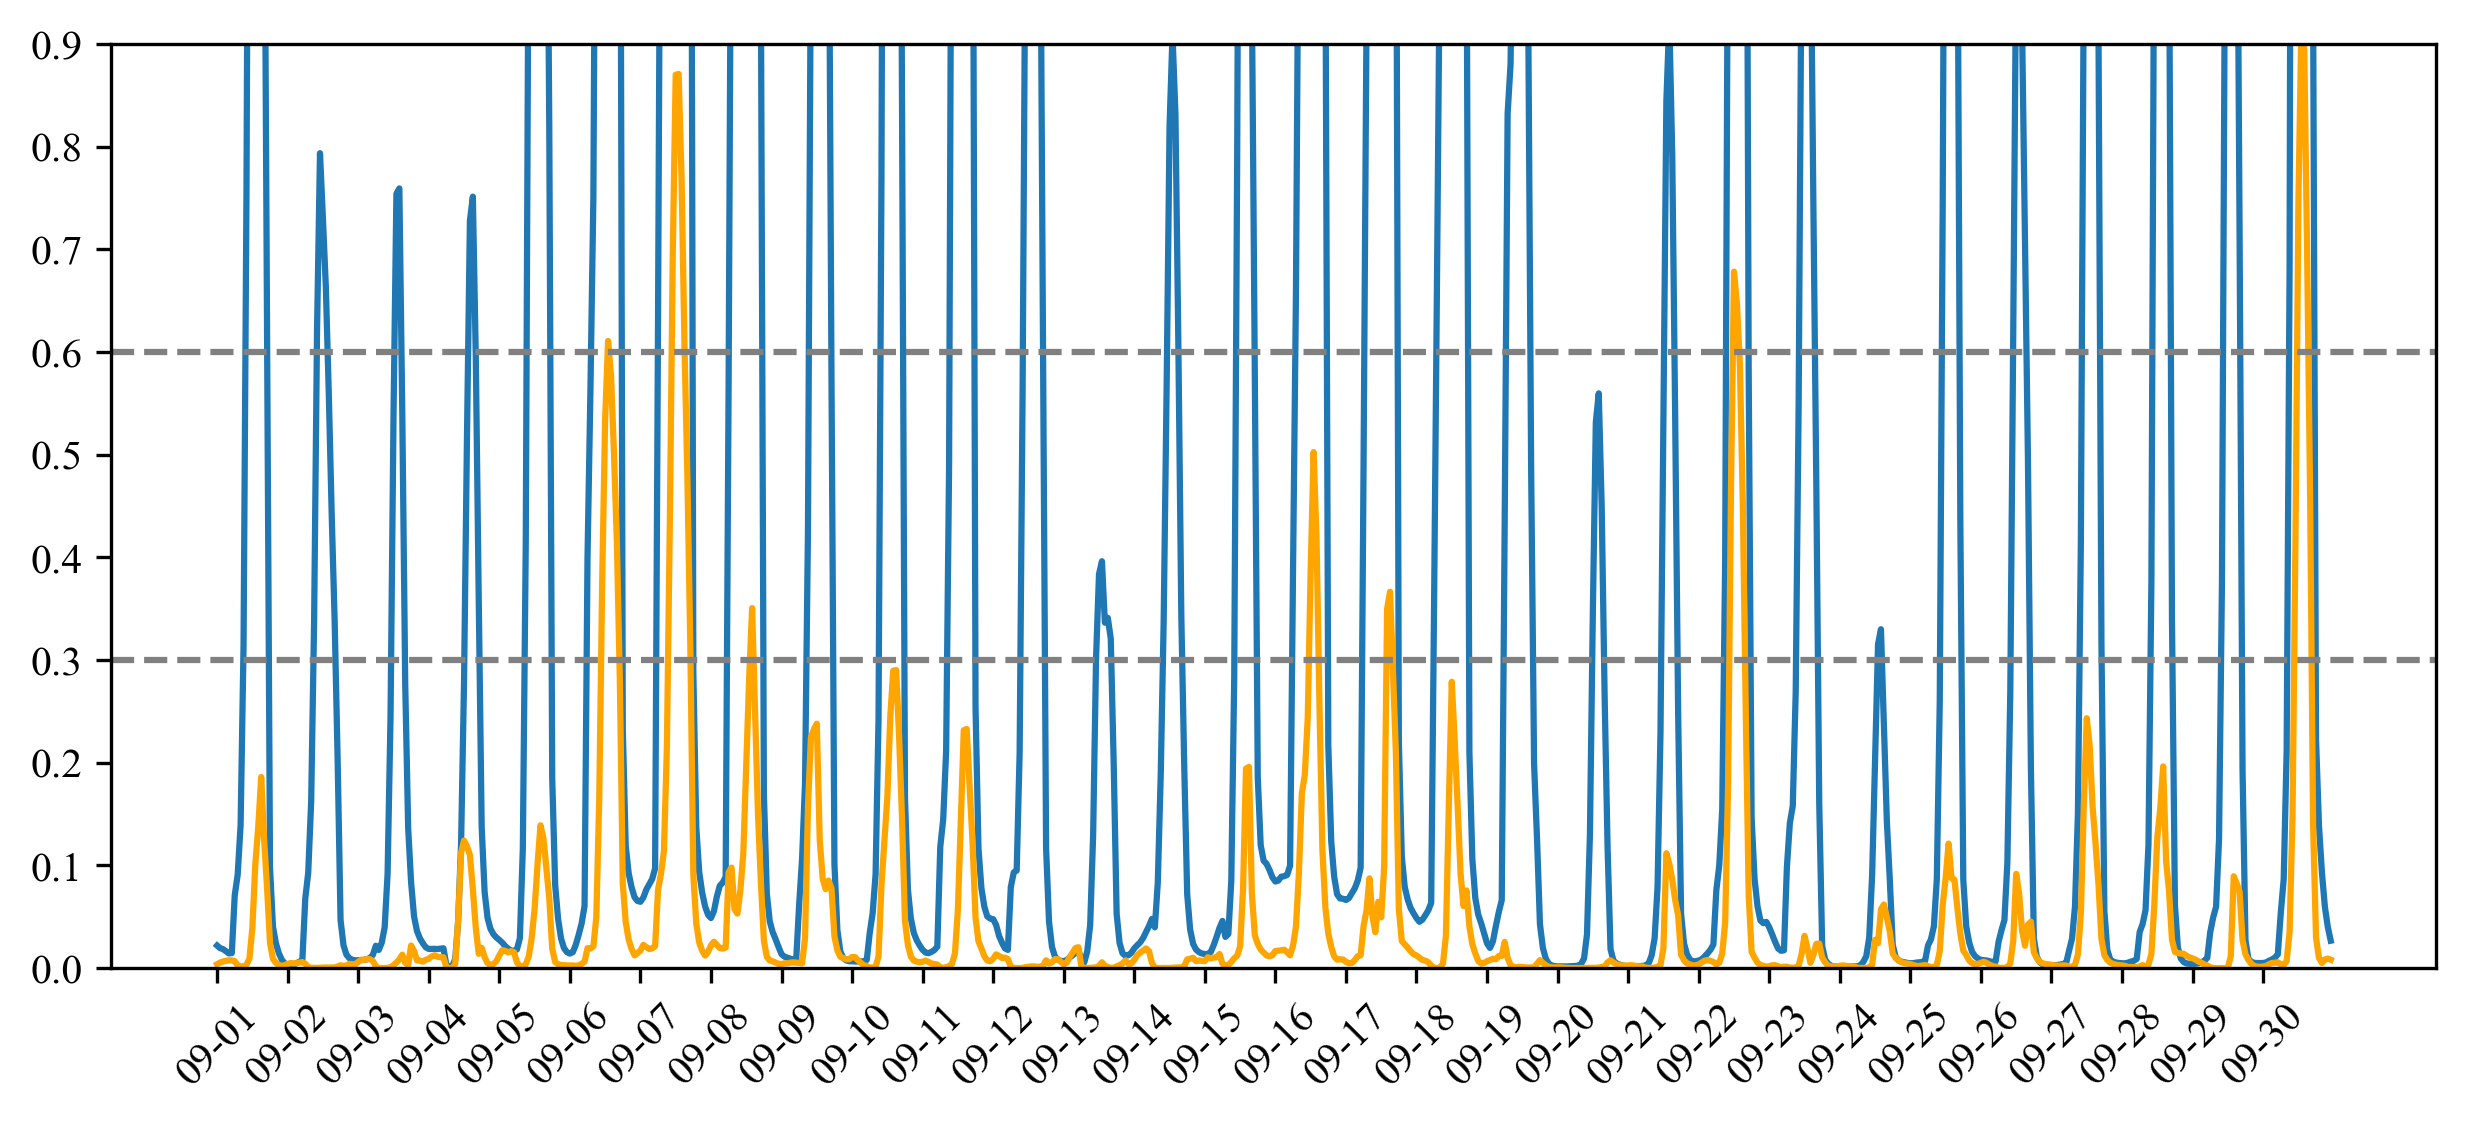

In [9]:
fig=plt.figure(figsize=(10,4),dpi=300)
ax=fig.subplots(1,1)

ts = np.arange(0,720)
ax.plot(ts,mean_hz,linestyle='-',color='tab:blue',label='hangzhou')
ax.plot(ts,mean_xs,linestyle='-',color='orange',label='xiaoshan')

ax.axhline(y=0.3,linestyle='--',color='gray')
ax.axhline(y=0.6,linestyle='--',color='gray')
ax.set_ylim(0,0.9)

ax.set_xticks(np.arange(0,720,24))
ax.set_xticklabels(pd.date_range('2022-09-01','2022-09-30',freq='D').strftime('%m-%d'),rotation=45)

plt.show()

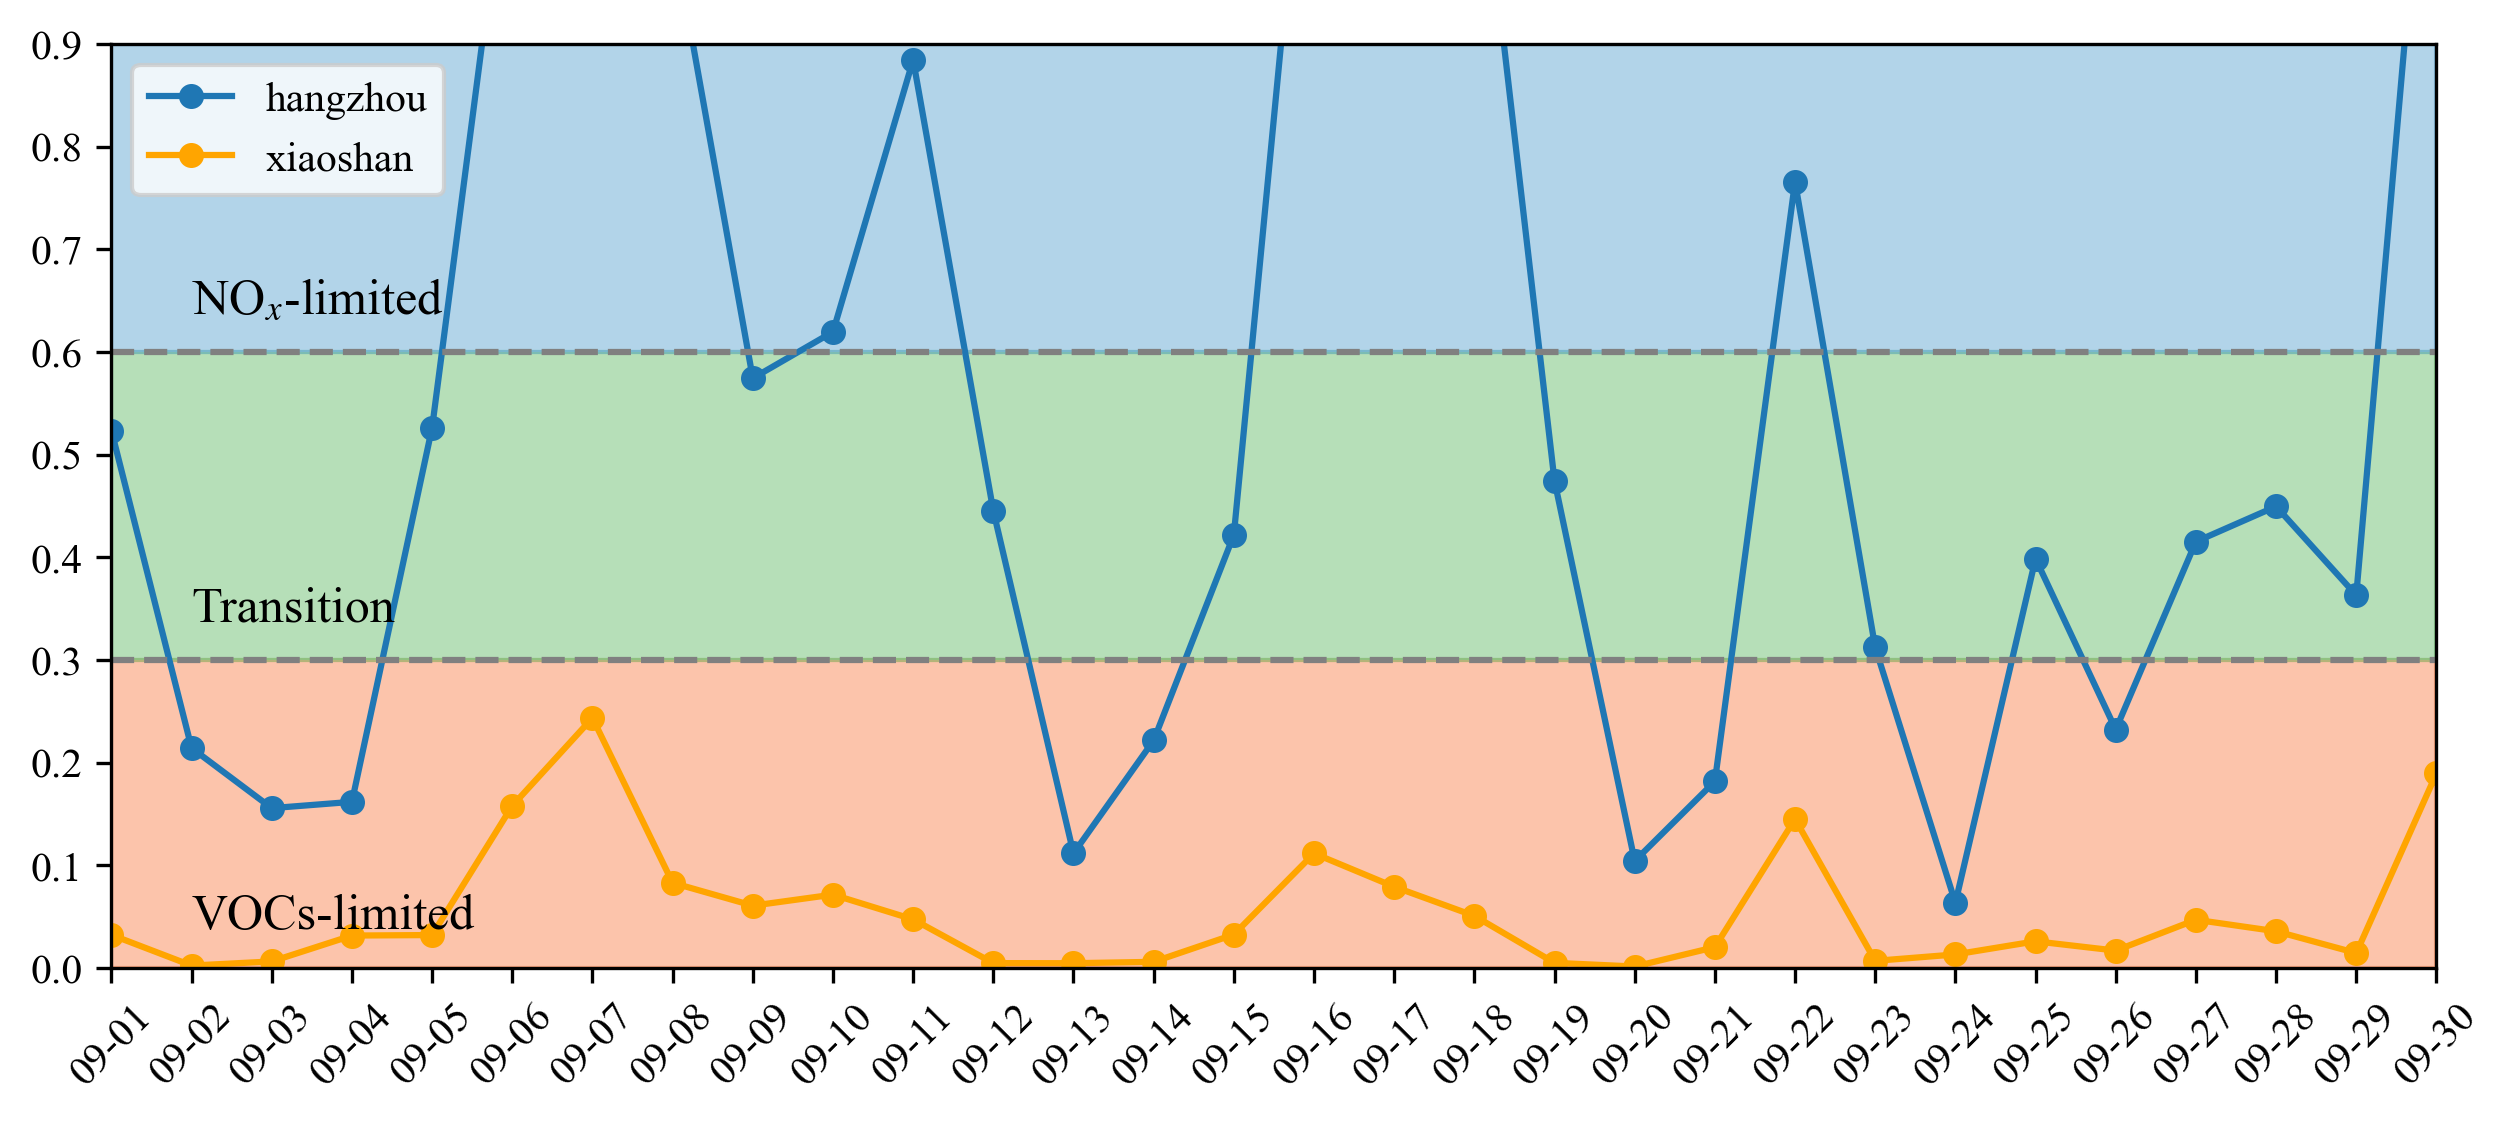

In [11]:
fig=plt.figure(figsize=(10,4),dpi=300)
ax=fig.subplots(1,1)

ts = np.arange(0,30)
ax.plot(ts,hz_day,marker='.',markersize=10,color='tab:blue',label='hangzhou')
ax.plot(ts,xs_day,marker='.',markersize=10,color='orange',label='xiaoshan')

ax.axhline(y=0.3,linestyle='--',color='gray')
ax.axhline(y=0.6,linestyle='--',color='gray')
ax.set_xlim(0,29)
ax.set_ylim(0,0.9)

ax.set_xticks(np.arange(0,30))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'),rotation=45)
ax.legend()

ax.fill_between(ts, 0, 0.3, color='#fb8b58',alpha=0.5)
ax.fill_between(ts, 0.3, 0.6, color='#6ec173',alpha=0.5)
ax.fill_between(ts, 0.6, 0.9, color='#66abd4',alpha=0.5)

ax.text(x=1,y=0.05,s='VOCs-limited',ha='left',va='center',fontsize=12)
ax.text(x=1,y=0.35,s='Transition',ha='left',va='center',fontsize=12)
ax.text(x=1,y=0.65,s='NO$_x$-limited',ha='left',va='center',fontsize=12)

plt.show()

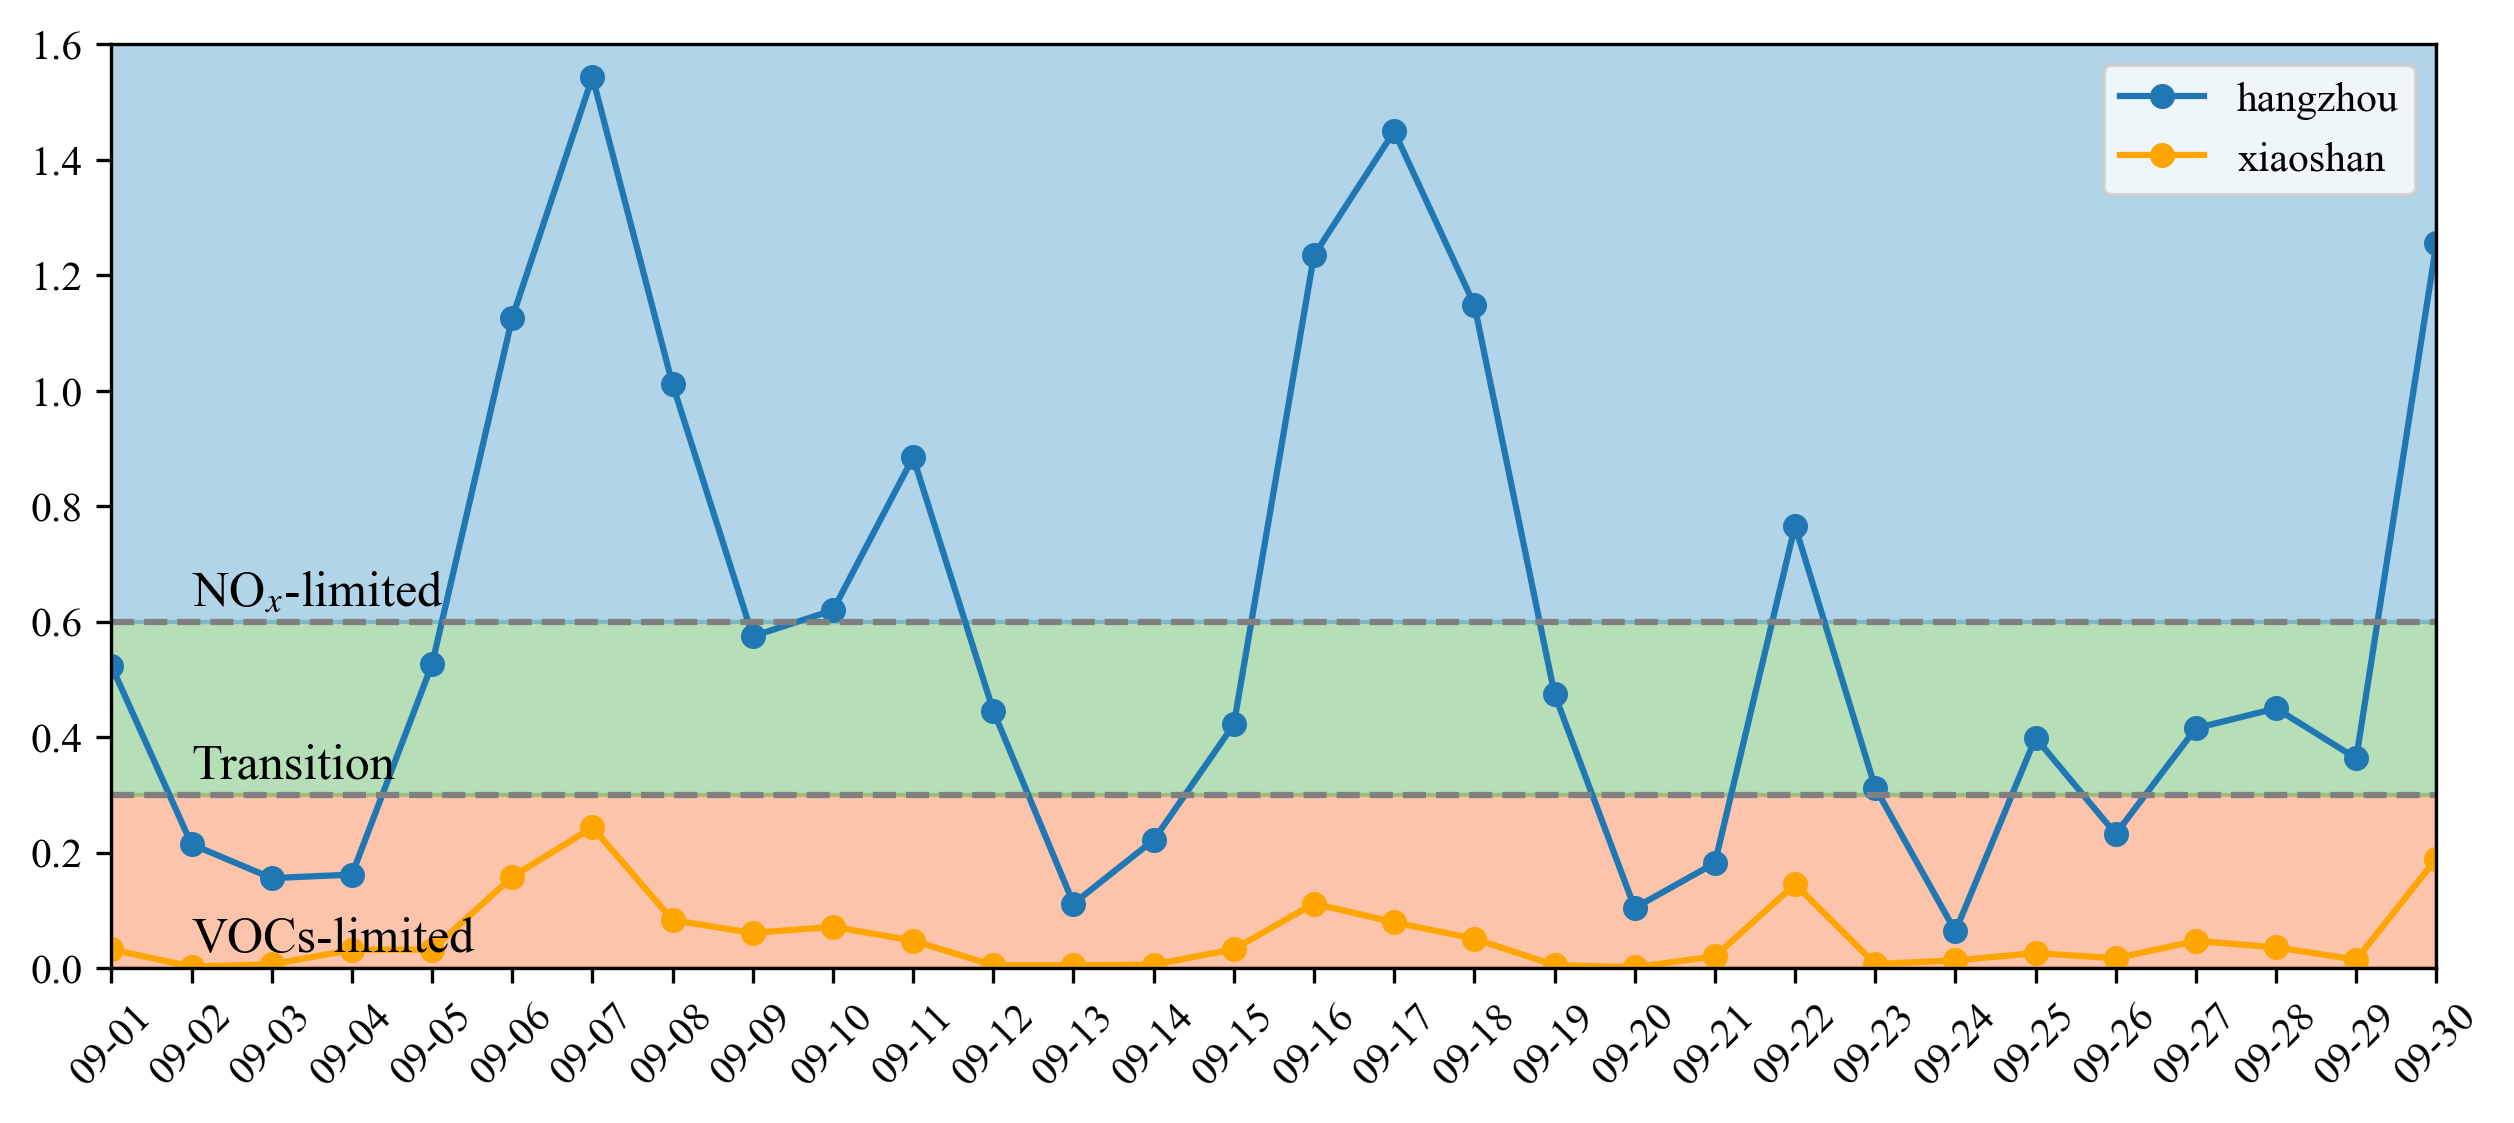

In [14]:
fig=plt.figure(figsize=(10,4),dpi=300)
ax=fig.subplots(1,1)

ts = np.arange(0,30)
ax.plot(ts,hz_day,marker='.',markersize=10,color='tab:blue',label='hangzhou')
ax.plot(ts,xs_day,marker='.',markersize=10,color='orange',label='xiaoshan')

ax.axhline(y=0.3,linestyle='--',color='gray')
ax.axhline(y=0.6,linestyle='--',color='gray')
ax.set_xlim(0,29)
ax.set_ylim(0,1.6)

ax.set_xticks(np.arange(0,30))
ax.set_xticklabels(pd.date_range(timestart,timeend,freq='D').strftime('%m-%d'),rotation=45)
ax.legend()

ax.fill_between(ts, 0, 0.3, color='#fb8b58',alpha=0.5)
ax.fill_between(ts, 0.3, 0.6, color='#6ec173',alpha=0.5)
ax.fill_between(ts, 0.6, 1.6, color='#66abd4',alpha=0.5)

ax.text(x=1,y=0.05,s='VOCs-limited',ha='left',va='center',fontsize=12)
ax.text(x=1,y=0.35,s='Transition',ha='left',va='center',fontsize=12)
ax.text(x=1,y=0.65,s='NO$_x$-limited',ha='left',va='center',fontsize=12)

plt.show()